# Importing Dataset

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# K-Means Clustering Necessary Imports
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

# Random Forest Necessary Imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

#make the plots show up inline
%matplotlib inline

In [72]:
# Representing data
iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [73]:
iris.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [74]:
X_iris = iris.drop('species', axis=1)
X_iris.shape

(150, 4)

In [75]:
y_iris = iris['species']
y_iris.shape
#iris

(150,)

In [76]:
y_iris

0         setosa
1         setosa
2         setosa
3         setosa
4         setosa
         ...    
145    virginica
146    virginica
147    virginica
148    virginica
149    virginica
Name: species, Length: 150, dtype: object

In [77]:
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(X_iris, y_iris, test_size=0.2)

In [78]:
type(X_train_iris)

pandas.core.frame.DataFrame

In [79]:
rfclf_iris = RandomForestClassifier()
rfclf_iris.fit(X_train_iris, y_train_iris)

y_prediction_iris = rfclf_iris.predict(X_test_iris)

In [80]:
y_prediction_iris

array(['versicolor', 'virginica', 'virginica', 'versicolor', 'setosa',
       'setosa', 'versicolor', 'versicolor', 'virginica', 'virginica',
       'setosa', 'versicolor', 'setosa', 'virginica', 'setosa',
       'virginica', 'virginica', 'virginica', 'setosa', 'setosa',
       'setosa', 'versicolor', 'setosa', 'virginica', 'setosa', 'setosa',
       'setosa', 'versicolor', 'setosa', 'virginica'], dtype=object)

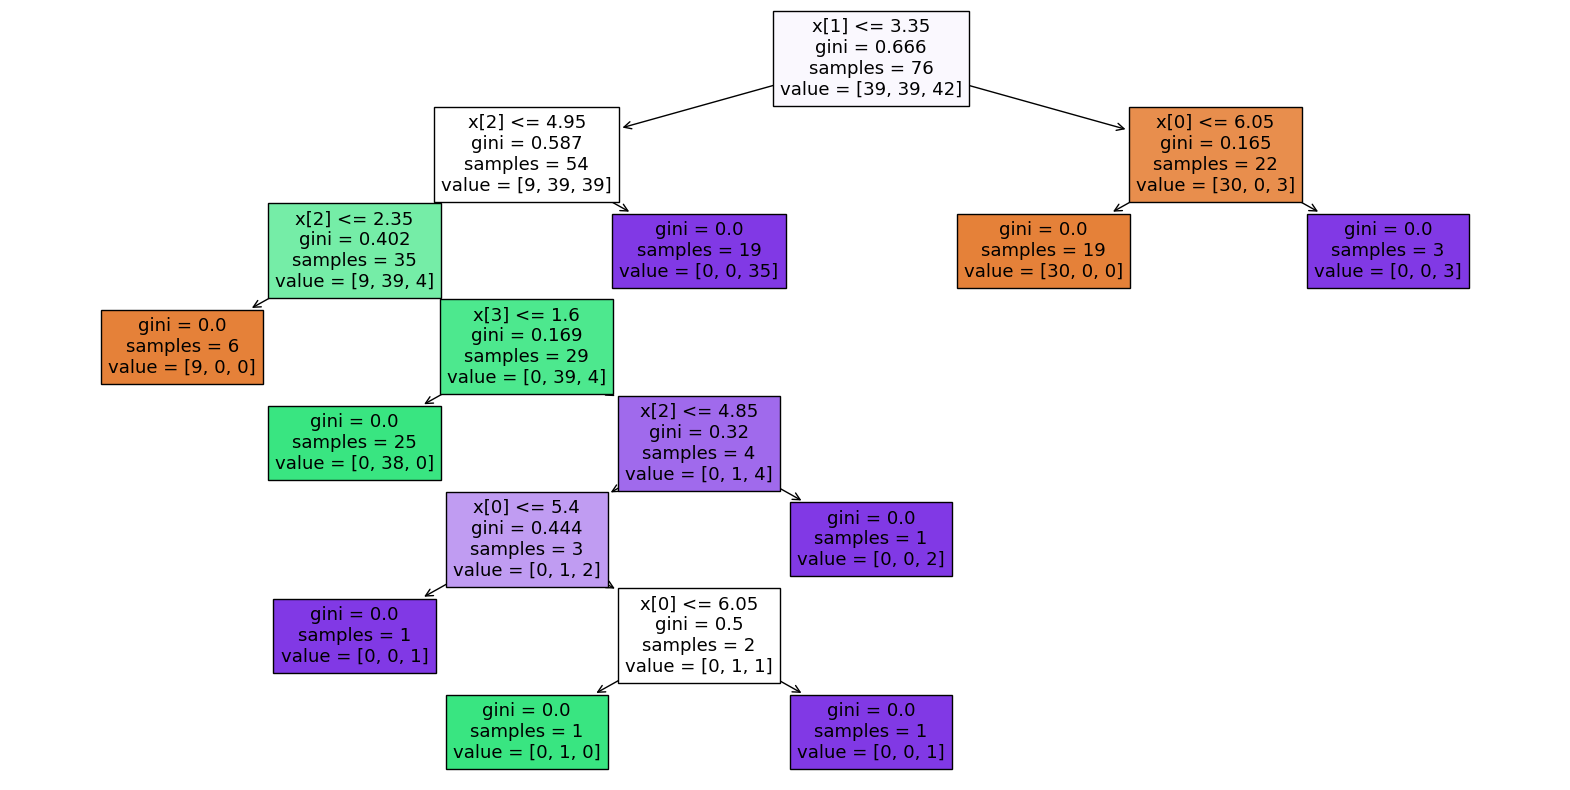

In [47]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(rfclf_iris.estimators_[1], filled=True)
plt.show()

In [49]:
tree = rfclf_iris.estimators_[1]
tree_structure = tree.tree_

# Get the node assignment for each sample
node_indices = tree.apply(X_iris)

C:\Users\adamr\anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names



In [33]:
tree_structure = tree.tree_

left_child = tree_structure.children_right[0]

node_indices = tree.apply(X_train_iris)

samples_in_left_child = np.where(node_indices == left_child)[0]

print(samples_in_left_child)

[]


C:\Users\adamr\anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names



In [35]:
def print_samples_for_each_node(tree, node_indices):
    num_nodes = tree.tree_.node_count  # Total number of nodes in the tree
    
    for node_id in range(num_nodes):
        # Get the indices of samples that belong to the current node
        samples_in_node = np.where(node_indices == node_id)[0]
        
        # Print the node and its corresponding samples
        print(f"Node {node_id}:")
        print(samples_in_node)  # Print indices of samples in the node
        print()  # Newline for readability
print_samples_for_each_node(tree, node_indices)

Node 0:
[]

Node 1:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]

Node 2:
[]

Node 3:
[]

Node 4:
[50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 71 72 73 74
 75 76 78 79 80 81 82 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99]

Node 5:
[]

Node 6:
[119 133 134]

Node 7:
[]

Node 8:
[83]

Node 9:
[129]

Node 10:
[ 70  77 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115
 116 117 118 120 121 122 123 124 125 126 127 128 130 131 132 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 149]



In [23]:
# Code that builds the tree structure that we need

In [59]:

feature_names = iris.columns

In [62]:
X_train_iris

,sepal_length,sepal_width,petal_length,petal_width
43,5.0,3.5,1.6,0.6
23,5.1,3.3,1.7,0.5
27,5.2,3.5,1.5,0.2
0,5.1,3.5,1.4,0.2
137,6.4,3.1,5.5,1.8
...,...,...,...,...
9,4.9,3.1,1.5,0.1
114,5.8,2.8,5.1,2.4
132,6.4,2.8,5.6,2.2
136,6.3,3.4,5.6,2.4


In [82]:
import dash
from dash import dcc, html, Input, Output
import plotly.graph_objects as go
import pandas as pd
from dash.dash_table import DataTable
import io
import numpy as np

# Extract feature names for label display
feature_names = X_train_iris.columns.tolist()

# Extract a single decision tree estimator from the forest
tree = rfclf_iris.estimators_[1]
tree_structure = tree.tree_

# Define a binary search tree node class with a DataFrame
class Node:
    def __init__(self, value, pos, color, data):
        self.value = value
        self.left = None
        self.right = None
        self.pos = pos
        self.color = color
        self.data = data  # Store a DataFrame in each node

# Recursively create a binary tree based on the decision tree structure
def create_bst_from_tree(tree, X, node_id=0, pos=(0, 0), depth=0):
    if node_id == -1:
        return None
    
    # Check if node is a leaf node
    if tree.tree_.feature[node_id] == -2:
        value = "Leaf (ID:" + str(node_id) + ")"
    else:
        feature = tree.tree_.feature[node_id]
        threshold = tree.tree_.threshold[node_id]
        value = f"{feature_names[feature]} <= {threshold:.2f}"

    color = 'red' if depth == 0 else ('green' if depth % 2 == 0 else 'blue')
    
    # Find the samples in the current node
    node_indices = tree.apply(X)
    samples_in_node = np.where(node_indices == node_id)[0]
    data = pd.DataFrame(X.iloc[samples_in_node], columns=feature_names)
    
    # Create node with the data
    node = Node(value, pos, color, data)

    # Left and right child nodes
    left_child_id = tree.tree_.children_left[node_id]
    right_child_id = tree.tree_.children_right[node_id]
    
    # Positioning logic for visualization
    left_pos = (pos[0] - 1 / (depth + 1), pos[1] - 1)
    right_pos = (pos[0] + 1 / (depth + 1), pos[1] - 1)

    node.left = create_bst_from_tree(tree, X, left_child_id, left_pos, depth + 1)
    node.right = create_bst_from_tree(tree, X, right_child_id, right_pos, depth + 1)

    return node

# Extract nodes recursively for visualization
def extract_nodes(node, nodes):
    if node is not None:
        nodes.append((node.value, node.pos, node.color, node.data, node))
        extract_nodes(node.left, nodes)
        extract_nodes(node.right, nodes)

# Create the tree and extract nodes
bst_root = create_bst_from_tree(tree, X_train_iris)
nodes = []
extract_nodes(bst_root, nodes)

# Prepare the data for Plotly
node_labels = [f"{value} ({color})" for value, _, color, _, _ in nodes]
node_positions = [pos for _, pos, _, _, _ in nodes]
node_colors = [color for _, _, color, _, _ in nodes]

# Create a Plotly figure
fig = go.Figure()

# Add nodes and connect each parent to its left and right children
for (value, (x, y), color, _, node) in nodes:
    fig.add_trace(go.Scatter(
        x=[x], y=[y],
        mode='markers+text',
        marker=dict(size=50, color=color),
        text=[value],
        textposition='middle center',
        textfont=dict(size=14),
        name=str(value),
        hoverinfo='text'
    ))

    # Connect to left child if it exists
    if node.left:
        fig.add_trace(go.Scatter(
            x=[x, node.left.pos[0]], y=[y, node.left.pos[1]],
            mode='lines',
            line=dict(color='black')
        ))

    # Connect to right child if it exists
    if node.right:
        fig.add_trace(go.Scatter(
            x=[x, node.right.pos[0]], y=[y, node.right.pos[1]],
            mode='lines',
            line=dict(color='black')
        ))

# Layout adjustments
fig.update_layout(
    title='Binary Search Tree Visualization',
    showlegend=False,
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    height=600,
    width=800,
    paper_bgcolor='white'
)

# Initialize the Dash app
app = dash.Dash(__name__)

# Layout of the app
app.layout = html.Div([
    html.H1("Binary Search Tree Visualization"),
    dcc.Graph(
        id='bst-graph',
        figure=fig,
        config={'displayModeBar': True}
    ),
    html.Div([
        html.Hr(),
        html.H3("Node Data"),
        html.Div(id='node-dataframe'),
    ], style={'margin': '20px'}),

    html.Div([
        html.Hr(),
        html.H3("Describe Output"),
        html.Div(id='node-describe'),
    ], style={'margin': '20px'}),

    html.Div([
        html.Hr(),
        html.H3("Info Output"),
        html.Pre(id='node-info-output')
    ], style={'margin': '20px'})
])

# Callback to update the DataTable on node click
@app.callback(
    [Output('node-dataframe', 'children'),
     Output('node-describe', 'children'),
     Output('node-info-output', 'children')],
    Input('bst-graph', 'clickData')
)
def display_node_info(clickData):
    if clickData is None:
        return '', '', ''

    # Get the node value clicked
    node_value = clickData['points'][0]['text']
    
    # Find the corresponding node and return its DataFrame
    for value, pos, color, data, _ in nodes:
        if value in node_value:
            describe_df = data.describe().reset_index()
            describe_df.rename(columns={'index': 'Statistic'}, inplace=True)
            
            describe_table = DataTable(
                columns=[{"name": i, "id": i} for i in describe_df.columns],
                data=describe_df.to_dict('records'),
                style_table={'overflowX': 'auto'},
                style_cell={'textAlign': 'left', 'padding': '5px'}
            )
            
            buffer = io.StringIO()
            data.info(buf=buffer)
            info_output = buffer.getvalue()
            
            dataframe_table = DataTable(
                columns=[{"name": i, "id": i} for i in data.columns],
                data=data.to_dict('records'),
                style_table={'overflowX': 'auto'},
                style_cell={'textAlign': 'left', 'padding': '5px'}
            )
            
            return dataframe_table, describe_table, info_output

    return '', '', ''

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True, port=8053)

C:\Users\adamr\anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

C:\Users\adamr\anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

C:\Users\adamr\anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

C:\Users\adamr\anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

C:\Users\adamr\anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

C:\Users\adamr\anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

C:\Users\adamr\anaconda3\lib\site-packag